# 0. Intall Dependencies and Bring in Data

In [ ]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
df = pd.read_csv(os.path.join('data', 'train.csv'))

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df[df['threat']==0].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## 0.1 Reduce GPU Memory Consumption

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,  True)

# 1. Preprocess

In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [8]:
X

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [9]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [10]:
MAX_FEATURES = 200_000 # number of words in the vocab

In [11]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_mode='int',
                               output_sequence_length=1800)

In [12]:
vectorizer.adapt(X.values)

In [13]:
vectorizer('Hello World, I love cats!')[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 286,  261,    8,  454, 4368], dtype=int64)>

In [14]:
vectorized_text = vectorizer(X.values)

In [15]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  643,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2506, ...,     0,     0,     0],
       [  425,   440,    70, ...,     0,     0,     0],
       ...,
       [32141,  7329,   383, ...,     0,     0,     0],
       [    5,    12,   533, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [16]:
len(X)

159571

In [17]:
# MCSHBAP - map, cache, shuffle, batch, prefetch | from_tensor_slices, list_files
original_dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
cached_dataset = original_dataset.cache()
shuffle_dataset = cached_dataset.shuffle(160_000)
batched_dataset = shuffle_dataset.batch(16)

dataset = batched_dataset.prefetch(8) # helps prevent bottlenecks

In [18]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [19]:
int(len(dataset)*.7)

6981

In [20]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [21]:
train_generator = train.as_numpy_iterator()

In [22]:
train_generator.next()

(array([[ 386,    5,    8, ...,    0,    0,    0],
        [   8,   69,   10, ...,    0,    0,    0],
        [1376,    8,  457, ...,    0,    0,    0],
        ...,
        [2953, 2783,   70, ...,    0,    0,    0],
        [  46,  167,   23, ...,    0,    0,    0],
        [   2,  997,  133, ...,    0,    0,    0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

# 2. Create Sequential Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [24]:
len(y[0])

6

In [25]:
model = Sequential()
# Crate Embedding Layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final Layer
model.add(Dense(6, activation='sigmoid'))

In [26]:
model.compile(loss="BinaryCrossentropy", optimizer="Adam")

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [28]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 1472s 210ms/step - loss: 0.0614 - val_loss: 0.0460


In [29]:
history.history

{'loss': [0.06136447936296463], 'val_loss': [0.046002261340618134]}

In [30]:
from matplotlib import pyplot as plt

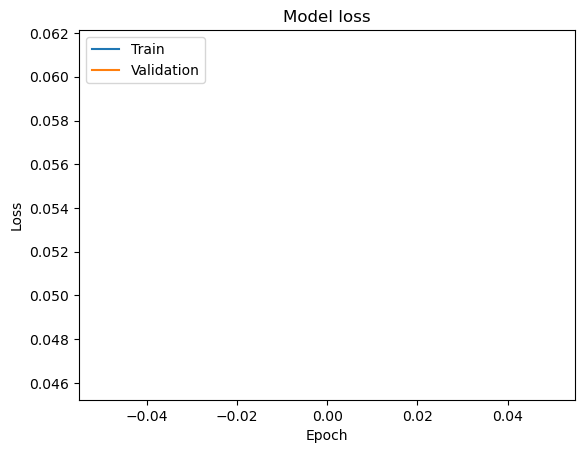

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()